### 3 classes - 4000/500

#### 1. load and preprocess data

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# print out examples
%matplotlib inline

unzip and load data

In [ ]:
# import zipfile

# # unzip the archive
# local_zip = './animal_data.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall()

# zip_ref.close()

set up paths

In [2]:
import os
# base directories
base_dir = './archive/afhq'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# directory with training animal pictures
train_cat_dir = os.path.join(train_dir, 'cat')
train_dog_dir = os.path.join(train_dir, 'dog')
train_wild_dir = os.path.join(train_dir, 'wild')

# directory with validation cat/dog pictures
val_cat_dir = os.path.join(val_dir, 'cat')
val_dog_dir = os.path.join(val_dir, 'dog')
val_wild_dir = os.path.join(val_dir, 'wild')

print("Contents of base directory:")
print(os.listdir(base_dir))
print("\nContents of train directory:")
print(os.listdir(train_dir))
print("\nContents of validation directory:")
print(os.listdir(val_dir))

Contents of base directory:
['train', 'val']

Contents of train directory:
['cat', 'dog', 'wild']

Contents of validation directory:
['cat', 'dog', 'wild']


check number of files/images

In [ ]:
# total number of files for each class
print('total training cat images :', len(os.listdir( train_cat_dir ) ))
print('total training dog images :', len(os.listdir( train_dog_dir ) ))
print('total training wild images :', len(os.listdir( train_wild_dir ) ))
print()

print('total validation cat images :', len(os.listdir( val_cat_dir ) ))
print('total validation dog images :', len(os.listdir( val_dog_dir ) ))
print('total validation wild images :', len(os.listdir( val_wild_dir ) ))

read image data

In [3]:
# define parameters
train_len = 4738
val_len = 500
N_train = 3 * train_len
N_val = 3 * val_len
# resize image to 150*159
D = 150 * 150

X_train = np.zeros((D, N_train))
X_val = np.zeros((D, N_val))

# read image from file
count = 0
for folder in os.listdir(train_dir):
    path = os.path.join(train_dir, folder)
    for fn in os.listdir(path):
        image = cv2.imread(os.path.join(path, fn), cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(image, (150, 150))
        X_train[:, count] = resized.reshape(D)
        count += 1

count = 0
for folder in os.listdir(val_dir):
    path = os.path.join(val_dir, folder)
    for fn in os.listdir(path):
        image = cv2.imread(os.path.join(path, fn), cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(image, (150, 150))
        X_val[:, count] = resized.reshape(D)
        count += 1

In [4]:
print(X_train.shape)
print(X_val.shape)

(22500, 14214)
(22500, 1500)


In [ ]:
X_data = np.concatenate((X_train.T, X_val.T), axis=0)

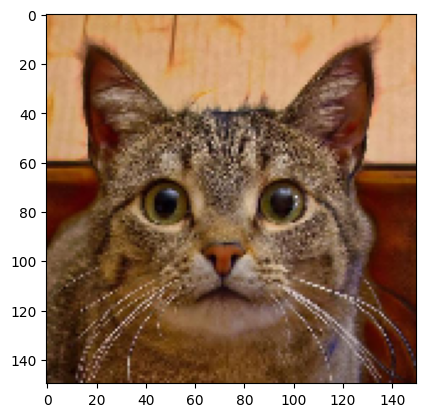

In [22]:
fn = './archive/afhq/train/cat/flickr_cat_000018.jpg'
tmp = mpimg.imread(fn)
img = cv2.resize(tmp, (150, 150))
plt.imshow(img, cmap='gray')

create labels array

In [10]:
# create label vectors Y: 0-cat, 1-cow, 2-dog, 3-horse, 4-sheep
Y_train = np.asarray([0]*train_len + [1]*train_len + [2]*train_len).T
Y_val = np.asarray([0]*val_len + [1]*val_len + [2]*val_len).T

print(Y_train.shape)
print(Y_val.shape)

(14214,)
(1500,)


#### 2. Naive Bayes Classifier

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##### orignal data

In [6]:
def toDF(X, Y):
    df = pd.DataFrame(X)
    label = pd.DataFrame(Y)
    return df, label

def calMu(df, label, n_class):
    return np.array([df[label[0] == i].mean().values 
                     for i in range(n_class)])

def calStd(df, label, n_class):
    return np.array([df[label[0] == i].std().values 
                     for i in range(n_class)])

In [7]:
def fit(X, Y, n_class):
    df, label = toDF(X, Y)
    mu_list = calMu(df, label, n_class)
    std_list = calStd(df, label, n_class)
    return mu_list, std_list

In [8]:
from scipy.stats import norm

def predict(X, mu_list, std_list, N, n_class):
    pred = []
    # likelihood = []
    # logsum_chk = []
    for n in range(N):
        classifier = []
        sample = X[n] # test sample
        # likelih = []
        for i in range(n_class):
            mu = mu_list[i]
            # var = np.square(std_list[i])
            # prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - mu)/(2 * var))
            std = std_list[i]
            prob = norm.pdf(sample, loc = mu, scale = std)
            result = np.sum(np.log(prob)) #, np.log(priors[i])) #not needed, we assume equal prior
            classifier.append(result)
            # likelih.append(prob)
        pred.append(np.argmax(classifier))
        # likelihood.append(likelih)
        # logsum_chk.append(classifier)
    return pred #, likelihood, logsum_chk

In [11]:
mu_ls, std_ls = fit(X_train.T, Y_train, 3)
print(mu_ls.shape)
print(std_ls.shape)
print(mu_ls)
print(std_ls)

(3, 22500)
(3, 22500)
[[119.66863656 119.55382018 119.46686366 ... 114.81405656 114.33284086
  113.97467286]
 [128.14288729 127.95377797 127.81152385 ... 124.8680878  124.43562685
  124.56690587]
 [105.26656817 105.63655551 105.89932461 ... 113.46306458 112.92465175
  112.86893204]]
[[69.5815439  69.4491228  69.40837366 ... 65.1144511  65.09582763
  64.93903047]
 [66.53183896 66.60147257 66.68587124 ... 64.33021628 63.95495114
  63.81909414]
 [59.11423148 59.27792255 59.39051672 ... 57.41977549 57.03228071
  56.80696216]]


In [12]:
pred_tr = predict(X_train.T, mu_ls, std_ls, len(Y_train), 3)
pred_te = predict(X_val.T, mu_ls, std_ls, len(Y_val), 3)

In [13]:
print(accuracy_score(Y_train, pred_tr))
print(accuracy_score(Y_val, pred_te))

0.5816096805965949
0.5653333333333334


In [14]:
print(confusion_matrix(Y_train, pred_tr))
print(confusion_matrix(Y_val, pred_te))

[[2189  966 1583]
 [ 782 2526 1430]
 [ 511  675 3552]]
[[211 109 180]
 [ 82 259 159]
 [ 52  70 378]]


In [ ]:
# fit model
clf = GaussianNB(priors=None)
clf.fit(X_train, Y_train)

# evaluate
Y_pred_train = clf.predict(X_train)
print("accuracy training score: ", accuracy_score(Y_train, Y_pred_train))
cm = confusion_matrix(Y_train, Y_pred_train)
print(cm)

Y_pred_val = clf.predict(X_val)
print("accuracy validation score: ", accuracy_score(Y_val, Y_pred_val))
cm = confusion_matrix(Y_val, Y_pred_val)
print(cm)

accuracy training score:  0.5815393274236668
[[2189  966 1583]
 [ 782 2526 1430]
 [ 512  675 3551]]
accuracy validation score:  0.5653333333333334
[[211 109 180]
 [ 82 259 159]
 [ 52  70 378]]


##### dim. reduction with PCA

In [ ]:
# perform PCA
pca2 = PCA(n_components=100)
X_train_pca2 = pca2.fit_transform(X_train.T)
print(X_train_pca2.shape)

X_val_pca2 = pca2.transform(X_val.T)
print(X_val_pca2.shape)

(14214, 100)
(1500, 100)


In [ ]:
mu_ls2, std_ls2 = fit(X_train_pca2, Y_train, 3)

In [ ]:
pred_tr2 = predict(X_train_pca2, mu_ls2, std_ls2, len(Y_train), 3)
pred_te2 = predict(X_val_pca2, mu_ls2, std_ls2, len(Y_val), 3)

In [ ]:
print(accuracy_score(Y_train, pred_tr2))
print(accuracy_score(Y_val, pred_te2))
print(confusion_matrix(Y_train, pred_tr2))
print(confusion_matrix(Y_val, pred_te2))

0.6243844097368791
0.642
[[2281 1123 1334]
 [ 746 3077  915]
 [ 418  803 3517]]
[[248 107 145]
 [ 75 331  94]
 [ 41  75 384]]


In [ ]:
# fit model
clf3 = GaussianNB(priors=None)
clf3.fit(X_train_pca2, Y_train)

# evaluate
Y_pred_train_3 = clf3.predict(X_train_pca2)
print("accuracy training score: ", accuracy_score(Y_train, Y_pred_train_3))
cm = confusion_matrix(Y_train, Y_pred_train_3)
print(cm)

Y_pred_val_3 = clf3.predict(X_val_pca2)
print("accuracy validation score: ", accuracy_score(Y_val, Y_pred_val_3))
cm = confusion_matrix(Y_val, Y_pred_val_3)
print(cm)

accuracy training score:  0.6244547629098073
[[2282 1123 1333]
 [ 747 3078  913]
 [ 418  804 3516]]
accuracy validation score:  0.642
[[248 107 145]
 [ 75 331  94]
 [ 41  75 384]]


##### with normalization

In [ ]:
# normalization
scaler = StandardScaler()
train_X = scaler.fit_transform(X_train.T)
val_X = scaler.transform(X_val.T)

In [ ]:
train_X.shape

(14214, 22500)

In [ ]:
# fit model
clf = GaussianNB(priors=None)
clf.fit(train_X, Y_train)

# evaluate
Y_pred_train = clf.predict(train_X)
print("accuracy training score: ", accuracy_score(Y_train, Y_pred_train))
cm = confusion_matrix(Y_train, Y_pred_train)
print(cm)

Y_pred_val = clf.predict(val_X)
print("accuracy validation score: ", accuracy_score(Y_val, Y_pred_val))
cm = confusion_matrix(Y_val, Y_pred_val)
print(cm)

accuracy training score:  0.5815393274236668
[[2189  966 1583]
 [ 782 2526 1430]
 [ 512  675 3551]]
accuracy validation score:  0.5653333333333334
[[211 109 180]
 [ 82 259 159]
 [ 52  70 378]]


In [ ]:
# perform PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(train_X)
print(X_train_pca.shape)

X_val_pca = pca.transform(val_X)
print(X_val_pca.shape)

(14214, 100)
(1500, 100)


In [ ]:
# fit model
clf2 = GaussianNB(priors=None)
clf2.fit(X_train_pca, Y_train)

# evaluate
Y_pred_train_2 = clf2.predict(X_train_pca)
print("accuracy training score: ", accuracy_score(Y_train, Y_pred_train_2))
cm = confusion_matrix(Y_train, Y_pred_train_2)
print(cm)

Y_pred_val_2 = clf2.predict(X_val_pca)
print("accuracy validation score: ", accuracy_score(Y_val, Y_pred_val_2))
cm = confusion_matrix(Y_val, Y_pred_val_2)
print(cm)

accuracy training score:  0.628605600112565
[[2326 1132 1280]
 [ 764 3076  898]
 [ 397  808 3533]]
accuracy validation score:  0.64
[[253 105 142]
 [ 78 325  97]
 [ 41  77 382]]


In [ ]:
mu_list, std_list = fit(X_train_pca, Y_train, 3)

In [ ]:
pred_tr = predict(X_train_pca, mu_list, std_list, len(Y_train), 3)
pred_te = predict(X_val_pca, mu_list, std_list, len(Y_val), 3)

In [ ]:
print(accuracy_score(Y_train, pred_tr))
print(accuracy_score(Y_val, pred_te))
print(confusion_matrix(Y_train, pred_tr))
print(confusion_matrix(Y_val, pred_te))

#### 3. Visualize results

In [ ]:
class Gaussian:
    @staticmethod
    def plot(X, mean, std, lower_bound=None, upper_bound=None, resolution=None,
        title=None, x_label=None, y_label=None, legend_label=None, legend_location="best"):
        
        # lower_bound = ( mean - 4*std ) if lower_bound is None else lower_bound
        # upper_bound = ( mean + 4*std ) if upper_bound is None else upper_bound
        # resolution  = 100
        
        title        = title        or "Gaussian Distribution"
        x_label      = x_label      or "x"
        y_label      = y_label      or "N(x|μ,σ)"
        # legend_label = legend_label or "μ={}, σ={}".format(mean, std)
        
        # X = np.linspace(lower_bound, upper_bound, resolution)
        dist_X = Gaussian._distribution(X, mean, std)
        
        plt.title(title)
        
        plt.plot(X, dist_X, label=legend_label)
        
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        # plt.legend(loc=legend_location)
        
        return plt
  
    @staticmethod
    def _distribution(X, mean, std):
        return 1./(np.sqrt(2*np.pi)*std)*np.exp(-0.5 * (1./std*(X - mean))**2)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as mp
import numpy as np

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5 * (1./sigma*(x - mu))**2)

for mu, sigma in zip(mu_ls[2], std_ls[2]): #(mu,sigma)
    plot = Gaussian.plot(X_train.T[0], mu, sigma, title="Gaussian Distribution for Class 'Wild'")
    # mp.plot(gaussian(np.linspace(-30, 30, 1000), mu, sigma))
    # mp.xlim(-100,100)  #set x-axes limits
    # mp.ylim(0,0.2)  #set y-axes limits

plot.show()

In [ ]:
X_train.T

In [ ]:
x = X_train.T[:100]
df_100 = pd.DataFrame(x)
mat_100 = df_100.corr()

In [ ]:
col = [i for i in range(100)]

In [ ]:
import seaborn as sns
sns.heatmap(mat_100[col][:100])
plt.show()  

In [ ]:
df_org = pd.DataFrame(X_train)
mat_org = df_org.corr()

In [ ]:
col = [i for i in range(50)]
submat = mat[col][:50]

In [ ]:
import seaborn as sns
sns.heatmap(mat)
plt.show()

#### PCA

In [ ]:
# Doing PCA, note that each row is a datapoint
from sklearn.decomposition import PCA

pca = PCA(n_components=225)

# then apply to data X
X_train_norm = pca.fit_transform(X_train.T)
print(X_train_norm.shape)

X_val_norm = pca.transform(X_val.T)
print(X_val_norm.shape)

(14214, 225)
(1500, 225)


In [ ]:
np.sum(pca.explained_variance_ratio_[:2]) * 100

29.897126016544906

In [ ]:
np.sum(pca.explained_variance_ratio_[:225]) * 100

85.13263386132792

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

lost_variance_ratio = np.sum(explained_variance_ratio)

print("Phần trăm thông tin sau khi giảm chiều về 225:", lost_variance_ratio * 100, "%")

Phần trăm thông tin sau khi giảm chiều về 225: 85.13263386132792 %


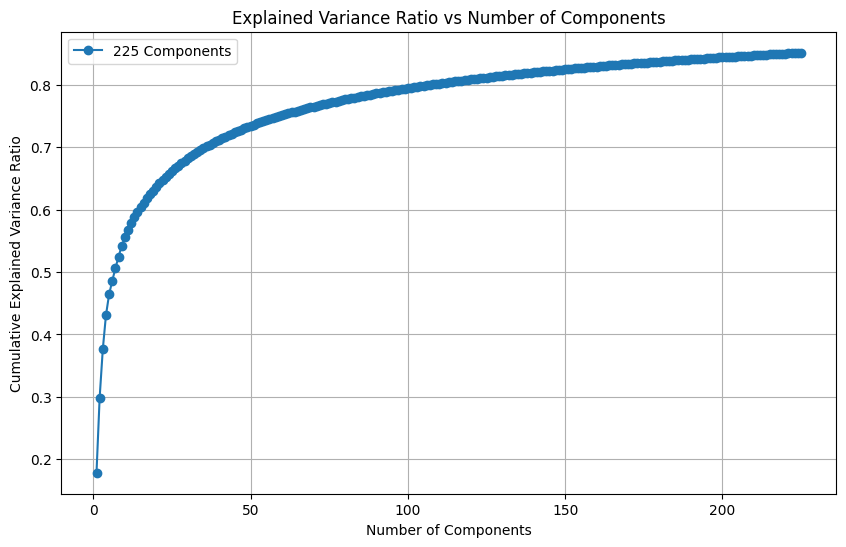

In [ ]:
ex = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(ex) + 1), ex, marker='o', label='225 Components')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Dimensions')

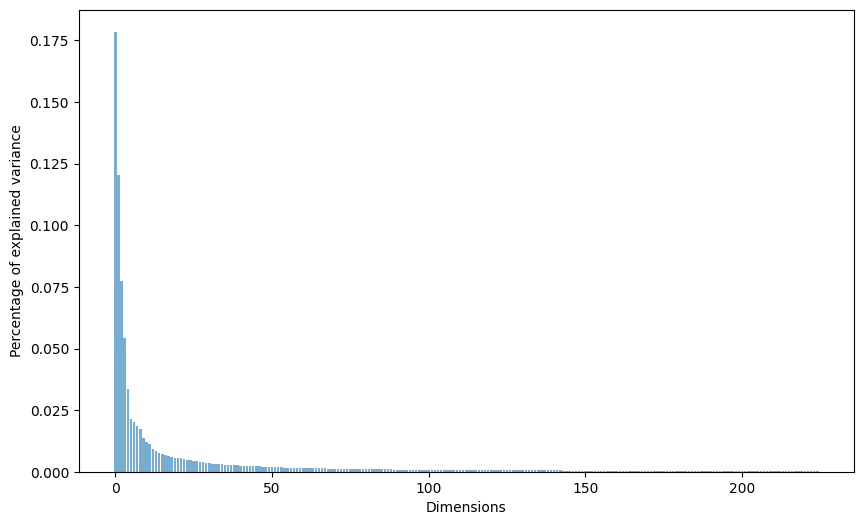

In [ ]:
# plotting the variance explained by each PC
explained_variance=pca.explained_variance_ratio_
plt.figure(figsize=(10,6))
plt.bar(range(225), explained_variance, alpha=0.6)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Dimensions')